In [8]:
from IPython.core.display import display, HTML
import GPy, numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
display(HTML("<style>.container { width:100% !important;align=center; }</style>"))
np.set_printoptions(precision=4, linewidth=200)

import seaborn as snb
snb.set(font_scale = 2.)

from scipy.stats import norm

In [9]:
# no observations of f
x = np.empty((0,1))
y = np.empty((0,1))

# observations of g'
M = 21

xd = np.linspace(0, 10, M)[:, None]
m = np.ones((M, 1))

sigma = 0.05

In [10]:
def sample_conditioned_on_derivatives(z, num_samples = 1, lengthscale=1.5, variance=10.):
    se = GPy.kern.RBF(input_dim = 1, lengthscale=lengthscale, variance=variance)
    se_der = GPy.kern.DiffKern(se, 0)

    gauss = GPy.likelihoods.Gaussian(variance=sigma**2)
    probit = GPy.likelihoods.Binomial(gp_link = GPy.likelihoods.link_functions.Probit(nu=100, fixed=False))

    # Then create the model, we give everything in lists
    m = GPy.core.MultioutputGP(X_list=[x, xd], Y_list=[y, z], kernel_list=[se, se_der], likelihood_list = [gauss, probit], inference_method=GPy.inference.latent_function_inference.EP(ep_mode="nested"))
    
    xp = np.linspace(0, 10, 101)
    X = np.zeros((101, 2))
    X[:, 0] = xp
    
    mu, Sigma = m.predict(X, include_likelihood=False, full_cov=True)

    L = np.linalg.cholesky(Sigma + 1e-6*np.identity(Sigma.shape[0]))


    return xp, mu + np.dot(L, np.random.normal(0, 1, size = (len(mu), num_samples)))


### Sample with deterministic z


$\begin{align}
p(\mathbf{f}, \mathbf{f}', \mathbf{z}, \mathbf{g}, \mathbf{g}', \mathbf{m}) = p(\mathbf{f}, \mathbf{f}')\prod_{i=1}^M \phi\left(z_if_i'\right)  p(\mathbf{g}, \mathbf{g}')\prod_{i=1}^M \phi\left(m_i g_i'\right) 
\end{align}$,

where $m$ is  the set of gradient observations for g, and  $z$ is  the set of gradient observations for f such that $z_i = 2\cdot\mathbb{I}\left[g_i > 0\right] - 1$

In [11]:
np.random.seed(0)
num_samples = 5

# sample g'
xp, g = sample_conditioned_on_derivatives(m, num_samples=num_samples)

# compute 
z = 2.*(g > 0) - 1.

# sample f conditioned on z
fs = np.stack([sample_conditioned_on_derivatives(zi[0::5, None])[1].ravel() for zi in z.T]).T

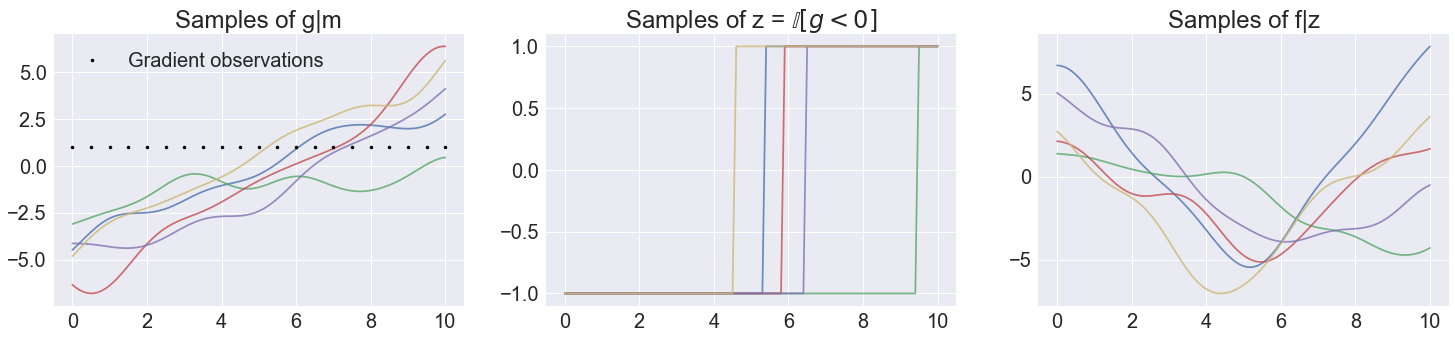

In [12]:
plt.figure(figsize = (25, 5))
plt.subplot(1, 3, 1)
plt.plot(xp, g, alpha = 0.8);
plt.plot(xd, m, 'k.', label = 'Gradient observations')
plt.title('Samples of g|m')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(xp, z, alpha = 0.8);
plt.title('Samples of z = $\mathbb{I}\\left[g<0\\right]$')
plt.subplot(1, 3, 3)
plt.plot(xp, fs, alpha = 0.8);
plt.title('Samples of f|z');

### Sample with stochastic z

$\begin{align}
p(\mathbf{f}, \mathbf{f}', \mathbf{z}, \mathbf{g}, \mathbf{g}', \mathbf{m}) = p(\mathbf{f}, \mathbf{f}')\prod_{i=1}^M \phi\left(z_if_i'\right)\prod_{i=1}^M \text{Ber}\left(z_i|\phi\left(g_i\right)\right)  p(\mathbf{g}, \mathbf{g}')\prod_{i=1}^M \phi\left(m_i g_i'\right) 
\end{align}$,

where $m$ is  the set of gradient observations for g, and  $z \in \left\lbrace-1, 1\right\rbrace$ is  the set of gradient observations

In [13]:
np.random.seed(0)

num_samples = 5

# sample g'
xp, g = sample_conditioned_on_derivatives(m, num_samples=num_samples)

# sample z
p = norm.cdf(g)
z = 2*np.random.binomial(1, p) -1


# sample f conditioned on z
fs = np.stack([sample_conditioned_on_derivatives(zi[0::5, None])[1].ravel() for zi in z.T]).T

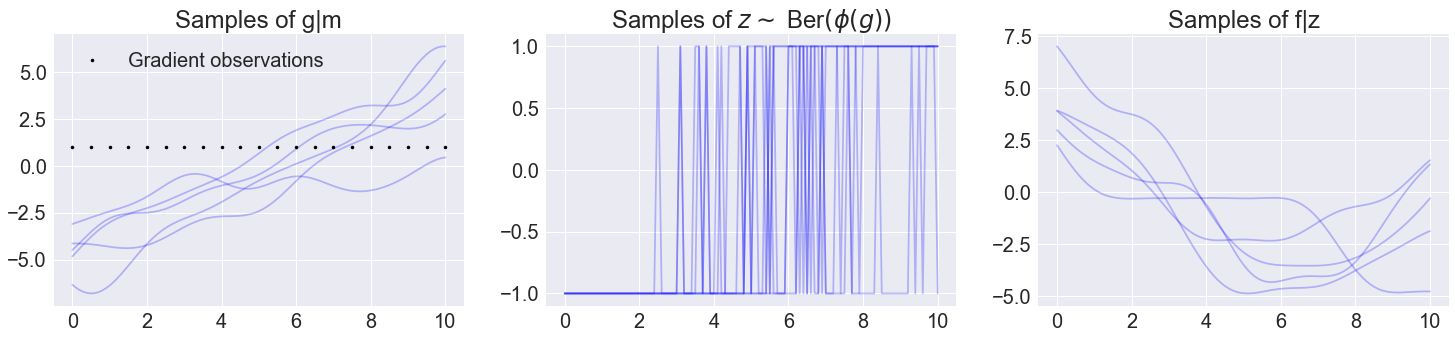

In [15]:
plt.figure(figsize = (25, 5))
plt.subplot(1, 3, 1)
plt.plot(xp, g, 'b-', alpha = 0.25);
plt.plot(xd, m, 'k.', label = 'Gradient observations')
plt.title('Samples of g|m')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(xp, z, 'b-', alpha = 0.25);
plt.title('Samples of $z \sim$ Ber$(\phi(g))$')

plt.subplot(1, 3, 3)
plt.plot(xp, fs, 'b-', alpha = 0.25);
plt.title('Samples of f|z');

